<a href="https://colab.research.google.com/github/AndreasGeorgiou03/PINODEs/blob/main/PINODE_Exp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchdiffeq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchdiffeq import odeint
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1. Problem setup: 4-DOF

# Parameters
c1 = c2 = c3 = 0.015
m1 = m2 = 9.0
m3 = 9.2


# Stiffness matrix K for a 3-DOF
K = torch.tensor([
    [20.26,   -11.16,   0.0],
    [-11.16,  20.33,    -9.17],
    [0.0,      -9.17,     9.17],
], dtype=torch.float32, device=device)

# Damping matrix (diagonal with c1..c3)
C = torch.diag(torch.tensor([c1, c2, c3], dtype=torch.float32, device=device))

# Mass Matrix
M = (1.0/386) * torch.diag(torch.tensor([m1, m2, m3], dtype=torch.float32, device=device))

r = torch.ones(3, device=device)          # participation vector
B = -(M @ r)      # (3,)

# Initial conditions for this experiment)
h0_1 = torch.tensor([ 2.0,  0.0, 0.0, 0.0,  0.0, -2.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_2 = torch.tensor([-2.0,  0.0, 0.0, -2.0,  0.0, 0.0], dtype=torch.float32, device=device)
h0_3 = torch.tensor([ 0.0,  4.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)
h0_4 = torch.tensor([ 0.0,  0.0,  0.0,  0.0, 0.0, 0.0], dtype=torch.float32, device=device)

h0_train = [h0_2]

# Read AT2 and resample to dt_model = 1/256 over the full physical duration

at2_path = "/content/drive/MyDrive/20251212_1765548540.60025_1/ath.KOBE.KBU000.AT2"

def read_at2(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()

    parts = lines[3].split()
    npts = int(parts[0])
    dt_file = float(parts[1])

    data_str = " ".join(lines[4:])
    acc = np.fromstring(data_str, sep=" ")
    acc = acc[:npts]  # safety
    return acc.astype(np.float32), dt_file, npts

u_file_np, dt_file, npts = read_at2(at2_path)

# File's physical timeline (dt_file = 0.01, NPTS=3200 -> ~31.99s)
T_end = (npts - 1) * dt_file
t_file = torch.arange(0.0, T_end + dt_file, dt_file)   # length npts

# Paper/integration grid
dt = 1.0 / 256.0
t_full = torch.arange(0.0, T_end + dt, dt, device=device)  # ~8193 points

# Resample acceleration onto t_full (linear interpolation)
u_full_np = np.interp(t_full.detach().cpu().numpy(),
                      t_file.numpy(),
                      u_file_np).astype(np.float32)

u_full = torch.tensor(u_full_np, device=device)


T_train_sec = 15.0
N_train = int(T_train_sec / dt) + 1
t_train = t_full[:N_train]
u_train = u_full[:N_train]




Using device: cpu


In [ ]:
class PINODEFuncScheme3_3DOF(nn.Module):
    def __init__(self, M, K, C, B):
        super().__init__()
        self.M = nn.Parameter(M.clone(), requires_grad=False)
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)
        self.B = nn.Parameter(B.clone().view(3), requires_grad=False)

        self.amp = 100.0
        self.u_fun = lambda t: torch.zeros((), device=self.M.device)  # scalar tensor

        # NN1: linear (no activation), 1 hidden layer with 10 neurons
        self.mlp = nn.Sequential(
            nn.Linear(6, 10),
            nn.Linear(10, 3)
        )

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (- self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)

        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)  # (3,)
        # base excitation: -1 * xg_ddot(t) on all DOFs
        xg_ddot = self.amp * self.u_fun(t)                # scalar
        a_base = -torch.ones_like(a_phys) * xg_ddot       # (...,3)

        a_disc = self.mlp(h)               # (3,)
        a = a_phys + a_disc + a_base

        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [ ]:
# Start from nominal
M_true = M.clone()
K_true = K.clone()
C_true = C.clone()

# Add controlled mismatch
K_true = 0.97 * K_true  # stiffness is 3% lower than nominal
C_true = 1.25 * C_true  # damping is 25% higher than nominal

# Base excitation forcing vector for true system
B_true = -(M_true @ r)      # (3,)

class TruthLinear3DOF(nn.Module):

    def __init__(self, M, K, C):
        super().__init__()
        self.M = M
        self.K = K
        self.C = C
        self.amp = 100.0
        self.u_fun = None  # will represent xg_ddot(t)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (- self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)

        xg_ddot = self.amp * self.u_fun(t)                 # scalar
        a_base  = -torch.ones_like(a_phys) * xg_ddot       # (...,3)

        a = a_phys + a_base
        return torch.cat([v, a], dim=-1)


In [ ]:
class UFunFromSamples:

    def __init__(self, t_grid: torch.Tensor, u_grid: torch.Tensor):
        assert t_grid.ndim == 1 and u_grid.ndim == 1, "t_grid and u_grid must be 1D"
        assert t_grid.numel() == u_grid.numel(), "t_grid and u_grid must have same length"
        self.t = t_grid
        self.u = u_grid

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # Accept scalar or vector t; return same shape
        t_in = t.reshape(-1)

        t0 = self.t[0]
        dt = self.t[1] - self.t[0]
        T = self.t.numel()

        # Convert t -> fractional index in [0, T-1)
        idx = ((t_in - t0) / dt).clamp(0, T - 1 - 1e-6)

        i0 = torch.floor(idx).long()
        i1 = (i0 + 1).clamp_max(T - 1)

        w = (idx - i0.float()).clamp(0.0, 1.0)

        out = (1.0 - w) * self.u[i0] + w * self.u[i1]
        return out.reshape(t.shape)


In [ ]:
truth = TruthLinear3DOF(M_true, K_true, C_true).to(device)
truth.u_fun = UFunFromSamples(t_full, u_full)

# define forcing function on the full horizon
u_fun_full = UFunFromSamples(t_full, u_full)

with torch.no_grad():
    traj_meas_full = odeint(truth, h0_4, t_full, method="rk4")  # (T_full, 6)

traj_meas_train = traj_meas_full[:N_train]  # (T_train, 6)

In [ ]:
def train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(
    scheme,
    model,
    h0,
    traj_true,
    t_train,
    u_grid,
    amp_scale=100.0,
    num_epochs=4000,
    lr=1e-3,
    log_interval=20,
    loss_log_path=None,
    loss_history_init=None,
    save_model_path=None,
    train_nsd_only=True,
    grad_clip_norm=1.0,
    power_penalty_lambda=0.0,
):

    model = model.to(device)
    model.train()

    # forcing
    model.u_fun = UFunFromSamples(t_train, u_grid.to(device))
    model.amp = float(amp_scale)

    # Freeze NN1 if requested
    if train_nsd_only:
        for p in model.mlp.parameters():
            p.requires_grad = False
        for p in model.nsd.parameters():
            p.requires_grad = True
        params = list(model.nsd.parameters())
    else:
        params = list(model.parameters())

    opt = optim.Adam(model.parameters(), lr=lr)
    # sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     opt,
    #     mode="min",
    #     factor=0.5,
    #     patience=50,
    #     threshold=1e-4,
    # )

    # --------- resume logic ----------
    loss_history_list = []
    global_epoch = 0
    if loss_history_init is not None:
        if isinstance(loss_history_init, np.ndarray):
            loss_history_list = loss_history_init.tolist()
        else:
            loss_history_list = list(loss_history_init)

        if len(loss_history_list) > 0:
            try:
                global_epoch = int(loss_history_list[-1][0])
            except Exception:
                global_epoch = 0
    # -------------------------------

    traj_true = traj_true.to(device)
    T = len(t_train)

    # Allow (T, D) or (T, B, D)
    assert traj_true.shape[0] == T, f"traj_true first dim must be T={T}, got {traj_true.shape[0]}"
    state_dim = traj_true.shape[-1]
    ndof = state_dim // 2

    x_true = traj_true[..., :ndof]
    v_true = traj_true[..., ndof:]

    # ---- loss normalization ----
    eps = 1e-8
    # std over time (and batch if present)
    reduce_dims = tuple(range(traj_true.ndim - 1))  # all dims except last
    sx = x_true.std(dim=reduce_dims, unbiased=False) + eps  # (ndof,)
    sv = v_true.std(dim=reduce_dims, unbiased=False) + eps  # (ndof,)
    # reshape for broadcasting: (1, ndof) or (1,1,ndof)
    while sx.ndim < x_true.ndim:
        sx = sx.unsqueeze(0)
        sv = sv.unsqueeze(0)
    # --------------------------------------

    print(f"\n=== Training single record (scheme {scheme}) for {num_epochs} epochs ===")
    print(f"amp_scale={amp_scale}, train_nsd_only={train_nsd_only}, power_penalty_lambda={power_penalty_lambda}")

    dt = t_train[1] - t_train[0]

    for local_epoch in range(1, num_epochs + 1):
        global_epoch += 1
        opt.zero_grad(set_to_none=True)

        pred = odeint(model, h0, t_train, method="rk4", options={"step_size": dt})

        # pred is typically (T, state_dim) or (T, B, state_dim)
        assert pred.shape == traj_true.shape, f"pred.shape={pred.shape}, traj_true.shape={traj_true.shape}"

        x_pred = pred[..., :ndof]
        v_pred = pred[..., ndof:]

        loss_x = torch.mean(((x_pred - x_true) / sx) ** 2)
        loss_v = torch.mean(((v_pred - v_true) / sv) ** 2)
        loss = loss_x + loss_v

        # Optional: discourage NN2 injecting energy (DOF1 only)
        # if power_penalty_lambda > 0.0:
        #     # Recompute NN2 on predicted states to estimate its "power"
        #     # a_nn2 is accel correction, power ~ a_nn2 * v1 (sign matters)
        #     a_raw = model.nsd(pred).squeeze(-1)           # works if nsd expects h
        #     a_nn2 = model.a_max * torch.tanh(a_raw)
        #     v1 = v_pred[..., 0]
        #     power = (a_nn2 * v1).mean()
        #     loss = loss + power_penalty_lambda * torch.relu(power)

        loss.backward()

        if grad_clip_norm is not None and grad_clip_norm > 0:
            torch.nn.utils.clip_grad_norm_(params, grad_clip_norm)

        opt.step()
        # sched.step(loss.item())

        if global_epoch % log_interval == 0:
            loss_history_list.append([global_epoch, float(loss.item())])

        if (local_epoch % 100 == 1) or (global_epoch % 10 == 0):
            print(
                f"[S{scheme}] Global {global_epoch:5d}, "
                f"Lx={loss_x.item():.3e}, Lv={loss_v.item():.3e}, Total={loss.item():.3e}"
            )

        if save_model_path is not None and (local_epoch % 10 == 0):
            torch.save(model.state_dict(), save_model_path)
            print(f"Saved model to {save_model_path}")

        if loss_log_path is not None and (local_epoch % 40 == 0):
            np.save(loss_log_path, np.array(loss_history_list, dtype=np.float32))
            print(f"Saved partial loss history to {loss_log_path}")

    loss_history_arr = np.array(loss_history_list, dtype=np.float32)

    if save_model_path is not None:
        torch.save(model.state_dict(), save_model_path)
        print(f"Saved model to {save_model_path}")

    if loss_log_path is not None:
        np.save(loss_log_path, loss_history_arr)
        print(f"\nSaved loss history to: {loss_log_path}")

    return model, loss_history_arr


In [ ]:
def train_phase2_lbfgs(
    scheme,
    model,
    h0,
    traj_true,
    t_train,
    u_grid,
    amp_scale=100.0,
    max_iters=300,
    lr=1.0,
    history_size=50,
    line_search_fn="strong_wolfe",
    train_nsd_only=True,
    grad_clip_norm=None,
    power_penalty_lambda=0.0,
    log_interval=10,
    save_model_path=None,
):
    model = model.to(device)
    model.train()

    # forcing
    model.u_fun = UFunFromSamples(t_train, u_grid.to(device))
    model.amp = float(amp_scale)

    traj_true = traj_true.to(device)
    T = len(t_train)
    assert traj_true.shape[0] == T, f"traj_true first dim must be T={T}, got {traj_true.shape[0]}"

    state_dim = traj_true.shape[-1]
    ndof = state_dim // 2

    x_true = traj_true[..., :ndof]
    v_true = traj_true[..., ndof:]

    # normalize losses (same idea as your Adam code)
    eps = 1e-8
    reduce_dims = tuple(range(traj_true.ndim - 1))
    sx = x_true.std(dim=reduce_dims, unbiased=False) + eps
    sv = v_true.std(dim=reduce_dims, unbiased=False) + eps
    while sx.ndim < x_true.ndim:
        sx = sx.unsqueeze(0)
        sv = sv.unsqueeze(0)

    # freeze NN1 if requested
    if train_nsd_only:
        for p in model.mlp.parameters():
            p.requires_grad = False
        for p in model.nsd.parameters():
            p.requires_grad = True
        params = list(model.nsd.parameters())
    else:
        params = list(model.parameters())

    opt = torch.optim.LBFGS(
        params,
        lr=lr,
        max_iter=10,                 # IMPORTANT: we call step() in a loop
        history_size=history_size,
        line_search_fn=line_search_fn,
    )

    print(f"\n=== L-BFGS Phase2 (scheme {scheme}) iters={max_iters} lr={lr} train_nsd_only={train_nsd_only} ===")

    loss_history = []
    dt = t_train[1] - t_train[0]

    def compute_loss_and_terms():
        pred = odeint(model, h0, t_train, method="rk4", options={"step_size": dt})
        assert pred.shape == traj_true.shape, f"pred.shape={pred.shape}, traj_true.shape={traj_true.shape}"

        x_pred = pred[..., :ndof]
        v_pred = pred[..., ndof:]

        loss_x = torch.mean(((x_pred - x_true) / sx) ** 2)
        loss_v = torch.mean(((v_pred - v_true) / sv) ** 2)
        loss = loss_x + loss_v



        # Optional: discourage NN2 injecting energy (DOF1 only)
        if power_penalty_lambda > 0.0:
            a_raw = model.nsd(pred).squeeze(-1)
            a_nn2 = model.a_max * torch.tanh(a_raw)
            v1 = v_pred[..., 0]
            power = (a_nn2 * v1).mean()
            loss = loss + power_penalty_lambda * torch.relu(power)

        return loss, loss_x, loss_v

    for it in range(1, max_iters + 1):
        def closure():
            opt.zero_grad(set_to_none=True)
            loss, _, _ = compute_loss_and_terms()
            loss.backward()

            if grad_clip_norm is not None and grad_clip_norm > 0:
                torch.nn.utils.clip_grad_norm_(params, grad_clip_norm)

            return loss

        loss_val = opt.step(closure)

        with torch.no_grad():
            loss, loss_x, loss_v = compute_loss_and_terms()

        if it % log_interval == 0 or it == 1:
            print(f"[S{scheme}] iter {it:4d}  Lx={loss_x.item():.3e}  Lv={loss_v.item():.3e}  Total={loss.item():.3e}")

        loss_history.append([it, float(loss.item())])

        if save_model_path is not None:
            torch.save(model.state_dict(), save_model_path)
            print(f"Saved model to {save_model_path}")

    if save_model_path is not None:
        torch.save(model.state_dict(), save_model_path)
        print(f"Saved model to {save_model_path}")

    return model, np.array(loss_history, dtype=np.float32)


In [ ]:

model = PINODEFuncScheme3_3DOF(M, K, C,B)

model.u_fun = UFunFromSamples(t_train, u_train)
model.amp = 100.0

save_path = "/content/drive/MyDrive/pinode_models/"

save_model_path = save_path + "exp3_wGroundAcc.pth"
loss_log_path = save_path + "exp3_wGroundAcc.npy"

save_model_path = save_path + "exp3_wGroundAcc_cDiff.pth"
model.load_state_dict(torch.load(save_model_path, map_location=device))


# model, loss_hist = train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(
#     scheme=3,
#     model=model,
#     h0=h0_4,
#     traj_true=traj_meas_train,
#     t_train=t_train,
#     u_grid=u_train,
#     amp_scale=100.0,
#     num_epochs=5000,
#     lr=1e-2,
#     log_interval=20,
#     loss_log_path=loss_log_path,
#     save_model_path=save_model_path,
#     loss_history_init=None,
# )




<All keys matched successfully>

In [ ]:
# --- set the forcing on the full horizon ---
model.eval()
model.u_fun = UFunFromSamples(t_full, u_full)
model.amp = 100.0

# --- extrapolate ---
with torch.no_grad():
    pred_full = odeint(model, h0_4, t_full, method="rk4")  # (N_full, 6)

# pred_full contains [x1 x2 x3 v1 v2 v3]
x_pred_full = pred_full[:, :3]
v_pred_full = pred_full[:, 3:]


In [ ]:
class PhysicsOnly3DOF(nn.Module):
    def __init__(self, M, K, C, B, t_grid, u_grid, amp=1.0):
        super().__init__()
        self.M, self.K, self.C, self.B = M, K, C, B
        self.u_fun = UFunFromSamples(t_grid, u_grid)
        self.amp = float(amp)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]
        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        rhs = rhs + self.B * (self.amp * self.u_fun(t))
        a = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)
        dh = torch.zeros_like(h)
        dh[..., :3] = v
        dh[..., 3:] = a
        return dh


In [ ]:
phys_only = PhysicsOnly3DOF(M, K, C, B, t_full, u_full, amp=100.0).to(device)

with torch.no_grad():
    traj_phys_full = odeint(phys_only, h0_4, t_full, method="rk4")  # (T_full,6)


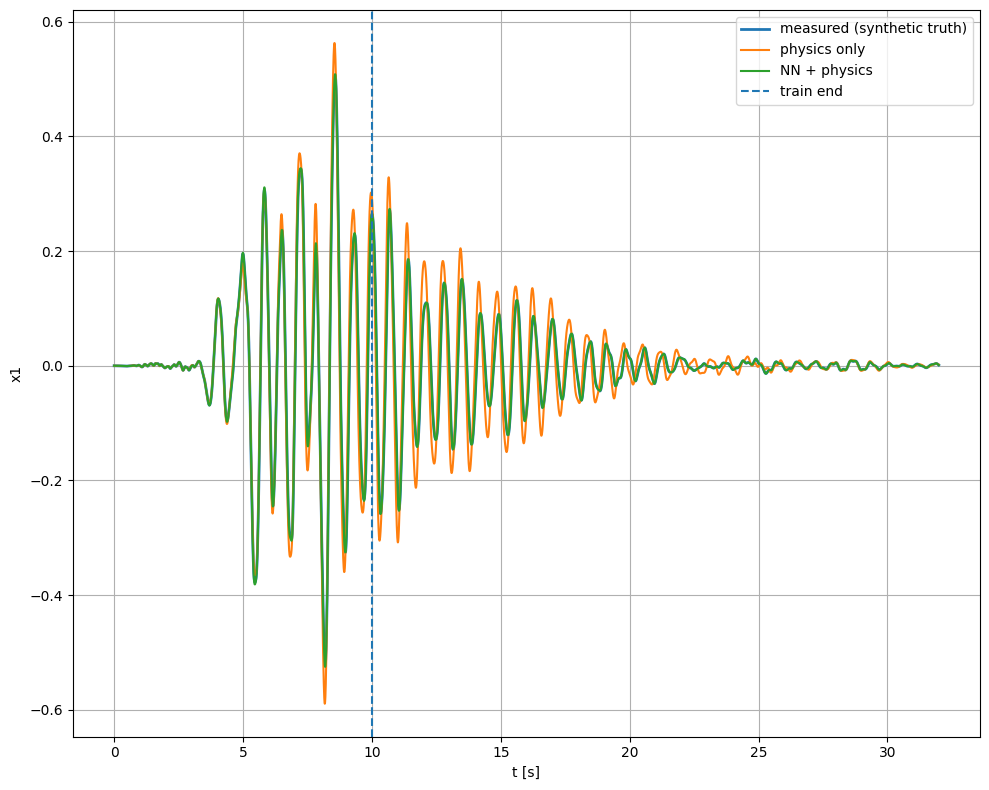

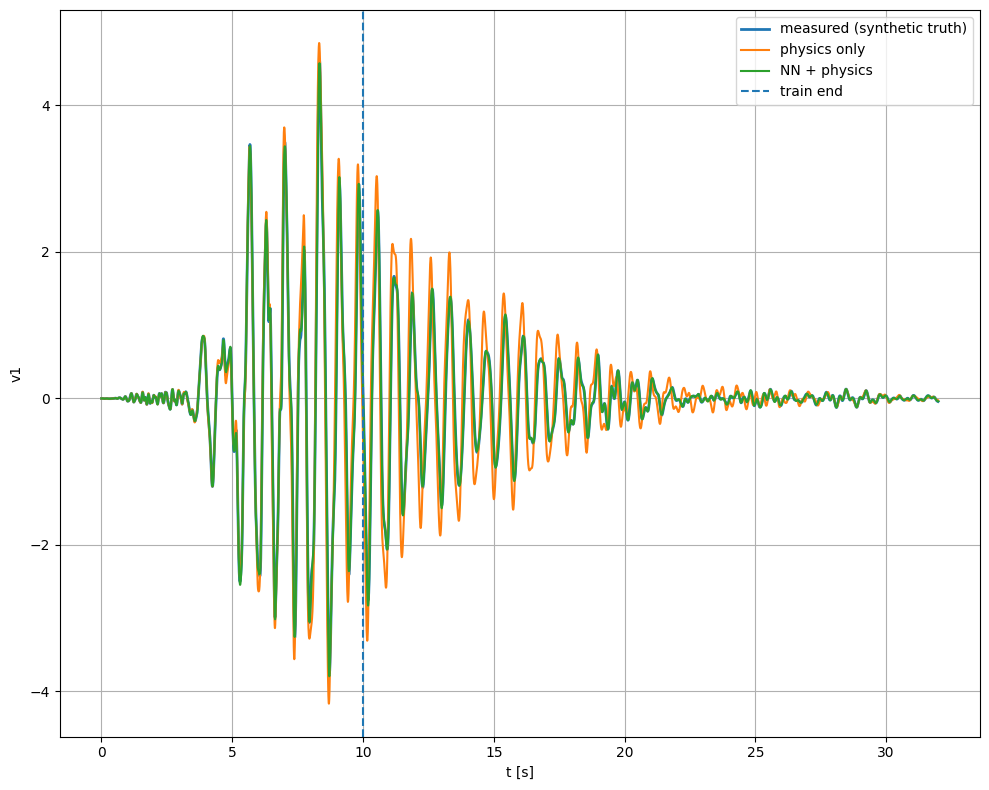

In [ ]:
tt = t_full.detach().cpu()
T_train_sec_2 = 10.0
# N_train_2 = int(T_train_sec_2 / dt) + 1
# t_train_2 = t_full[:N_train_2]

def plot_three(traj_meas, traj_phys, traj_nn, idx, ylabel, save_path=None):

    fig = plt.figure(figsize=(10, 8))

    y_meas = traj_meas[:, idx].detach().cpu()
    y_phys = traj_phys[:, idx].detach().cpu()
    y_nn   = traj_nn[:, idx].detach().cpu()

    plt.plot(tt, y_meas, label="measured (synthetic truth)", lw=2)
    plt.plot(tt, y_phys, label="physics only")
    plt.plot(tt, y_nn,   label="NN + physics")
    plt.axvline(T_train_sec_2, linestyle="--", label="train end")

    plt.xlabel("t [s]")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()



save_path_x = save_path + "exp3_noNSD_x1.png"
save_path_v = save_path + "exp3_noNSD_v1.png"
plot_three(traj_meas_full, traj_phys_full, pred_full, idx=0, ylabel="x1", save_path = save_path_x)
plot_three(traj_meas_full, traj_phys_full, pred_full, idx=3, ylabel="v1", save_path = save_path_v)


In [ ]:
# layer 1: Linear(6->10), layer 2: Linear(10->3)
L1 = model.mlp[0]
L2 = model.mlp[1]

with torch.no_grad():
    W1 = L1.weight.detach()   # (10, 6)
    b1 = L1.bias.detach()     # (10,)
    W2 = L2.weight.detach()   # (3, 10)
    b2 = L2.bias.detach()     # (3,)

    # Effective map: a_disc = W_eff h + b_eff
    W_eff = W2 @ W1                  # (3, 6)
    b_eff = b2 + W2 @ b1             # (3,)


Wx = W_eff[:, :3]   # (3,3) multiplies x
Wv = W_eff[:, 3:]   # (3,3) multiplies v


with torch.no_grad():
    K_upd = K - (M @ Wx)   # (3,3)
    C_upd = C - (M @ Wv)   # (3,3)


In [ ]:
print("K_true:\n", K_true)
print("K_upd:\n", K_upd)
print("K:\n", K)

print("C_true:\n", C_true)
print("C_upd:\n", C_upd)
print("C:\n", C)


K_true:
 tensor([[ 19.6522, -10.8252,   0.0000],
        [-10.8252,  19.7201,  -8.8949],
        [  0.0000,  -8.8949,   8.8949]])
K_upd:
 tensor([[ 19.9633, -11.3179,   0.1911],
        [-11.2632,  20.2642,  -9.1192],
        [  0.0777,  -9.1352,   9.0736]])
K:
 tensor([[ 20.2600, -11.1600,   0.0000],
        [-11.1600,  20.3300,  -9.1700],
        [  0.0000,  -9.1700,   9.1700]])
C_true:
 tensor([[0.0187, 0.0000, 0.0000],
        [0.0000, 0.0187, 0.0000],
        [0.0000, 0.0000, 0.0187]])
C_upd:
 tensor([[ 0.0301, -0.0230,  0.0010],
        [ 0.0049,  0.0114,  0.0079],
        [-0.0058,  0.0051,  0.0199]])
C:
 tensor([[0.0150, 0.0000, 0.0000],
        [0.0000, 0.0150, 0.0000],
        [0.0000, 0.0000, 0.0150]])


In [ ]:
def nsd_force_bilinear(x1, d0=0.15, k_post=-10.0):

    # amount beyond threshold
    excess = torch.relu(torch.abs(x1) - d0)
    return k_post * excess * torch.sign(x1)

In [ ]:
import torch
import torch.nn as nn

class TruthPhase2_3DOF(nn.Module):

    def __init__(self, M, K, C, nsd_force_fun):
        super().__init__()
        self.M, self.K, self.C = M, K, C
        self.nsd_force_fun = nsd_force_fun

        self.amp = 100.0
        self.u_fun = None  # will represent xg_ddot(t)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        # physics accel
        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)

        # base excitation accel (Eq. 18 bottom block)
        xg_ddot = self.amp * self.u_fun(t)                      # scalar
        a_base  = -torch.ones_like(a_phys) * xg_ddot            # (...,3)

        # NSD force on DOF1 -> convert to accel via M^{-1}
        f_nsd = self.nsd_force_fun(x[..., 0])                   # (...,)
        f_vec = torch.stack([f_nsd, torch.zeros_like(f_nsd), torch.zeros_like(f_nsd)], dim=-1)  # (...,3)
        a_nsd = torch.linalg.solve(self.M, f_vec.unsqueeze(-1)).squeeze(-1)                     # (...,3)

        a = a_phys + a_base + a_nsd
        return torch.cat([v, a], dim=-1)


In [ ]:
truth2 = TruthPhase2_3DOF(M_true, K_true, C_true, nsd_force_bilinear).to(device)

truth2.u_fun = UFunFromSamples(t_full, u_full)
truth2.amp = 100.0

with torch.no_grad():
    traj_meas2_full = odeint(truth2, h0_4, t_full, method="rk4")  # (T_full, 6)

traj_meas2_train = traj_meas2_full[:len(t_train)]


In [ ]:
class NSD_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 6 input features (x1, x2, x3, v1, v2, v3)
        # 20 hidden neurons, LeakyReLU activation
        self.mlp = nn.Sequential(
            nn.Linear(6, 20),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(20, 20),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(20, 1)  # Only output 1 (acceleration correction for DOF1)
        )

    def forward(self, h):
        return self.mlp(h)  # Output is a single value (accel correction for DOF1)


In [ ]:
class PINODEFuncScheme3_3DOF_with_NSD(nn.Module):
    def __init__(self, M, K, C, nn1_mlp, nn2_nsd, a_max=1.0):
        super().__init__()
        self.M = nn.Parameter(M.clone(), requires_grad=False)
        self.K = nn.Parameter(K.clone(), requires_grad=False)
        self.C = nn.Parameter(C.clone(), requires_grad=False)

        self.mlp = nn1_mlp
        self.nsd = nn2_nsd

        self.a_max = float(a_max)   # <-- bound magnitude
        self.amp = 1.0
        self.u_fun = lambda t: torch.zeros((), device=self.M.device)

    def forward(self, t, h):
        x = h[..., :3]
        v = h[..., 3:]

        rhs = (-self.K @ x.unsqueeze(-1) - self.C @ v.unsqueeze(-1)).squeeze(-1)
        a_phys = torch.linalg.solve(self.M, rhs.unsqueeze(-1)).squeeze(-1)

        xg_ddot = self.amp * self.u_fun(t)
        a_base = -torch.ones_like(a_phys) * xg_ddot

        a_nn1 = self.mlp(h)

        a_raw = self.nsd(h)

        a_nsd_vec = torch.zeros_like(a_phys)
        a_nsd_vec[..., 0] = a_raw

        a = a_phys + a_base + a_nn1 + a_nsd_vec
        return torch.cat([v, a], dim=-1)


In [ ]:
model.u_fun = UFunFromSamples(u_train, t_train)
nn2 = NSD_Net().to(device)
model_nsd = PINODEFuncScheme3_3DOF_with_NSD(M, K, C, model.mlp, nn2).to(device)

# freeze NN1
for p in model_nsd.mlp.parameters():
    p.requires_grad = False
model_nsd.mlp.eval()



Sequential(
  (0): Linear(in_features=6, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=3, bias=True)
)

In [ ]:
# save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_lbfgs1e10_025.pth"
save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_lbfgs1e10_1.pth"
loss_log_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.npy"

# loss_history_init = np.load(loss_log_path)

# save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_lbfgs1e10_1.pth"
# save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e10_1e3_continueV2.pth"
# save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e10_1e3_continueV2.pth"

save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth"
model_nsd.load_state_dict(torch.load(save_model_path, map_location=device))
save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth"
# save_model_path = "/content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_lbfgs1_retraining_originalarchitecture.pth"


model_nsd, loss_hist = train_scheme_with_disc_singleIC_singleEQ_exp3_no_nsd(
    scheme=3,
    model=model_nsd,
    h0=h0_4,
    traj_true=traj_meas2_train,
    t_train=t_train,
    u_grid=u_train,
    amp_scale=100.0,
    num_epochs=10000,
    lr=1e-2,
    log_interval=20,
    loss_log_path=loss_log_path,
    save_model_path=save_model_path,
    loss_history_init=[],
    train_nsd_only=True,
    grad_clip_norm=0.5,
    # power_penalty_lambda=1e-10,
)





=== Training single record (scheme 3) for 10000 epochs ===
amp_scale=100.0, train_nsd_only=True, power_penalty_lambda=0.0
[S3] Global     1, Lx=5.841e-04, Lv=2.544e-03, Total=3.128e-03
[S3] Global    10, Lx=6.833e-03, Lv=1.193e-02, Total=1.877e-02
Saved model to /content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth
[S3] Global    20, Lx=2.053e-03, Lv=5.945e-03, Total=7.999e-03
Saved model to /content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth
[S3] Global    30, Lx=9.253e-04, Lv=3.840e-03, Total=4.765e-03
Saved model to /content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth
[S3] Global    40, Lx=7.544e-04, Lv=3.058e-03, Total=3.812e-03
Saved model to /content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.pth
Saved partial loss history to /content/drive/MyDrive/pinode_models/exp3_NSD_wGroundAcc_adam1e2_retraining.npy
[S3] Global    50, Lx=6.262e-04, Lv=2.789e-03, Total=3.415e-03
Saved mod

KeyboardInterrupt: 

In [ ]:
model.eval()
model.u_fun = UFunFromSamples(t_full, u_full)
model.amp = 100.0

# --- extrapolate ---
with torch.no_grad():
    pred_train = odeint(model, h0_4, t_full, method="rk4")  # (N_full, 6)

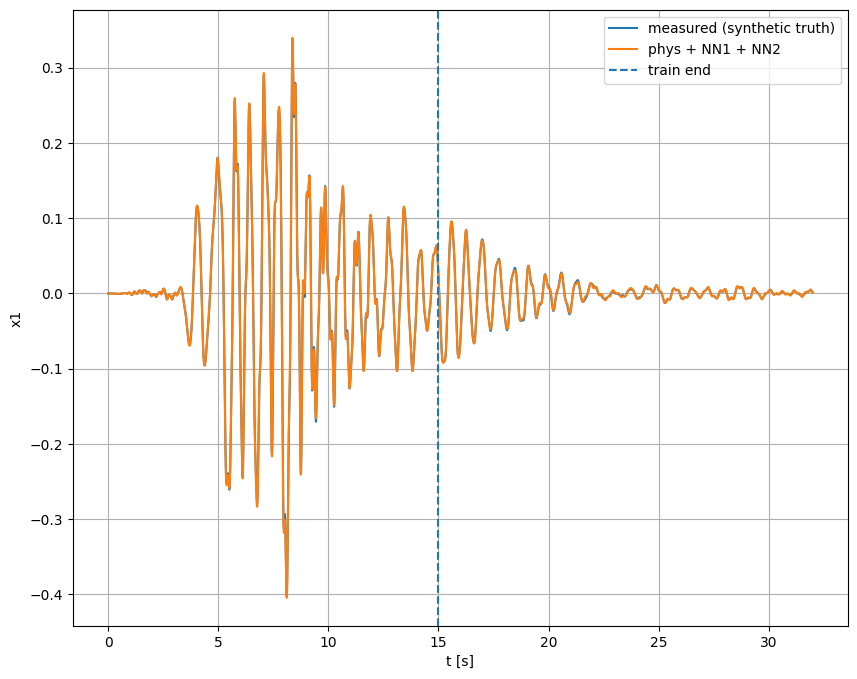

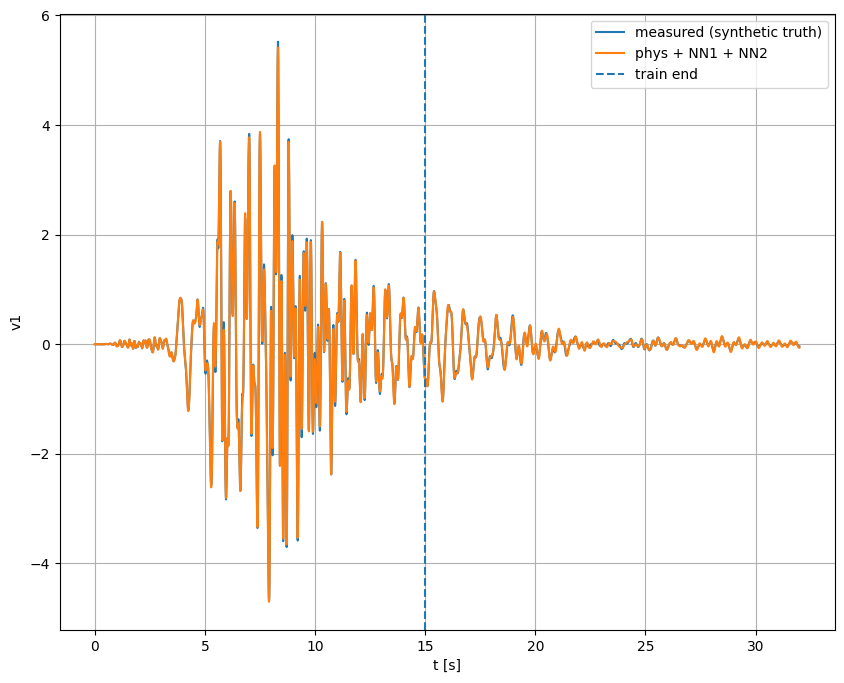

In [ ]:
tt = t_full.detach().cpu()

def plot_three_nsd(traj_meas, traj_phys, traj_nn, idx, ylabel, save_path):
    y_meas = traj_meas[:, idx].detach().cpu()
    y_phys = traj_phys[:, idx].detach().cpu()
    y_nn   = traj_nn[:, idx].detach().cpu()

    fig = plt.figure(figsize=(10, 8))
    plt.plot(tt, y_meas, label="measured (synthetic truth)")
    plt.plot(tt, y_phys, label="phys + NN1")
    plt.plot(tt, y_nn,   label="phys + NN1 + NN2")
    plt.axvline(T_train_sec, linestyle="--", label="train end")
    plt.xlabel("t [s]")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

def plot_two_nsd(traj_meas, traj_nn, idx, ylabel, save_path):
    y_meas = traj_meas[:, idx].detach().cpu()
    y_nn   = traj_nn[:, idx].detach().cpu()

    fig = plt.figure(figsize=(10, 8))
    plt.plot(tt, y_meas, label="measured (synthetic truth)")
    plt.plot(tt, y_nn,   label="phys + NN1 + NN2")
    plt.axvline(T_train_sec, linestyle="--", label="train end")
    plt.xlabel("t [s]")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


# --- set the forcing on the full horizon ---
model_nsd.eval()
model_nsd.u_fun = UFunFromSamples(t_full, u_full)
model_nsd.amp = 100.0

# --- extrapolate ---
with torch.no_grad():
    pred_train_nsd = odeint(model_nsd, h0_4, t_full, method="rk4")  # (N_full, 6)


save_path_x = save_path + "exp3_NSD_x1_compare"
save_path_v = save_path + "exp3_NSD_v1_compare"

# plot_three_nsd(traj_meas2_full, traj_meas2_full, pred_train_nsd , idx=0, ylabel="x1", save_path = save_path_x)
# plot_three_nsd(traj_meas2_full, traj_meas2_full, pred_train_nsd, idx=3, ylabel="v1", save_path = save_path_v)
plot_two_nsd(traj_meas2_full, pred_train_nsd , idx=0, ylabel="x1", save_path = save_path_x)
plot_two_nsd(traj_meas2_full, pred_train_nsd, idx=3, ylabel="v1", save_path = save_path_v)

In [ ]:
!pip install pysindy


In [ ]:
import numpy as np
import torch

def hinge_signed_np(x, d0):
    return np.sign(x) * np.maximum(np.abs(x) - d0, 0.0)

def finite_difference_acc(v, dt):
    a = torch.zeros_like(v)
    a[1:-1] = (v[2:] - v[:-2]) / (2.0 * dt)
    a[0]    = (v[1] - v[0]) / dt
    a[-1]   = (v[-1] - v[-2]) / dt
    return a

@torch.no_grad()
def build_bilinear_dataset_exp3(h_data, source="nn2",model_nsd=None,M_true=None,K_true=None,C_true=None,t_grid=None,u_fun=None,amp=100.0,amp_scale=1.0,device="cpu"):

    if M_true is None:
        raise ValueError("M_true is required.")
    M = M_true.to(device)

    # wrap single trajectory
    if isinstance(h_data, (list, tuple)):
        trajs = list(h_data)
    else:
        trajs = [h_data]

    x1_all, y_all = [], []

    if source.lower() == "nn2":
        if model_nsd is None:
            raise ValueError("For source='nn2', provide model_nsd.")
        model_nsd = model_nsd.to(device).eval()

        for h in trajs:
            h = h.to(device)
            if h.ndim != 2 or h.shape[1] != 6:
                raise ValueError(f"Expected (T,6), got {tuple(h.shape)}")

            x1 = h[:, 0]

            a_raw = model_nsd.nsd(h).squeeze(-1)         # (T,)

            a_vec = torch.zeros((h.shape[0], 3), device=device, dtype=h.dtype)
            a_vec[:, 0] = a_raw

            f_vec = (M @ a_vec.unsqueeze(-1)).squeeze(-1)  # (T,3)
            f1 = f_vec[:, 0]

            x1_all.append(x1.detach().cpu().numpy())
            y_all.append(f1.detach().cpu().numpy())

    elif source.lower() == "truth":
        # required args
        if any(arg is None for arg in [K_true, C_true, t_grid, u_fun]):
            raise ValueError("For source='truth', provide K_true, C_true, t_grid, and u_fun.")

        K = K_true.to(device)
        C = C_true.to(device)
        t_grid = t_grid.to(device)
        dt = float((t_grid[1] - t_grid[0]).item())

        # forcing samples on t_grid
        if callable(u_fun):
            u_samples = u_fun(t_grid).to(device)  # (T,)
        else:
            u_samples = u_fun.to(device)          # (T,)

        for h in trajs:
            h = h.to(device)
            if h.ndim != 2 or h.shape[1] != 6:
                raise ValueError(f"Expected (T,6), got {tuple(h.shape)}")

            x = h[:, :3]
            v = h[:, 3:]
            x1 = x[:, 0]

            # a_true from finite difference of v
            a_true = finite_difference_acc(v, dt)  # (T,3)

            # a_phys = M^{-1}(-Kx - Cv)
            rhs = (-K @ x.unsqueeze(-1) - C @ v.unsqueeze(-1)).squeeze(-1)  # (T,3)
            a_phys = torch.linalg.solve(M, rhs.unsqueeze(-1)).squeeze(-1)   # (T,3)

            # a_base = -xg_ddot * 1
            xg_ddot = amp_scale * float(amp) * u_samples                    # (T,)
            a_base = -torch.ones_like(a_phys) * xg_ddot.unsqueeze(-1)       # (T,3)

            a_disc = a_true - a_phys - a_base                               # (T,3)
            f_disc = (M @ a_disc.unsqueeze(-1)).squeeze(-1)                 # (T,3)
            f1 = f_disc[:, 0]

            x1_all.append(x1.detach().cpu().numpy())
            y_all.append(f1.detach().cpu().numpy())

    else:
        raise ValueError("source must be 'nn2' or 'truth'.")

    x1 = np.concatenate(x1_all, axis=0)
    y_force = np.concatenate(y_all, axis=0)
    return x1, y_force


def recover_bilinear_nsd_exp3(h_data,source="nn2",model_nsd=None,M_true=None,K_true=None,C_true=None,t_grid=None,u_fun=None,amp=100.0,amp_scale=1.0,d0_grid=None,device="cpu"):

    x1, y = build_bilinear_dataset_exp3(h_data=h_data,source=source,model_nsd=model_nsd,M_true=M_true,K_true=K_true,C_true=C_true,t_grid=t_grid,u_fun=u_fun,amp=amp,amp_scale=amp_scale,device=device)

    if d0_grid is None:
        xmax = np.percentile(np.abs(x1), 99)
        d0_grid = np.linspace(0.0, 0.9 * xmax, 400)

    best = None
    for d0 in d0_grid:
        phi = hinge_signed_np(x1, d0)
        denom = (phi @ phi) + 1e-12
        k = (phi @ y) / denom
        yhat = k * phi
        rmse = float(np.sqrt(np.mean((y - yhat) ** 2)))
        if best is None or rmse < best["rmse"]:
            best = {"d0": float(d0), "k_post": float(k), "rmse": rmse, "source": source}

    return best


In [ ]:
best_truth = recover_bilinear_nsd_exp3(
    h_data=traj_meas2_train,
    source="truth",
    M_true=M,
    K_true=K_true,
    C_true=C_true,
    t_grid=t_train,
    u_fun=UFunFromSamples(t_train, u_train),
    amp=100.0,
    device=device,
)
print(best_truth)


{'d0': 0.15025068819522858, 'k_post': -10.006489753723145, 'rmse': 0.002686211606487632, 'source': 'truth'}


In [ ]:
best_nn2 = recover_bilinear_nsd_exp3(
    h_data=traj_meas2_train,
    source="nn2",
    model_nsd=model_nsd,
    M_true=M,
    device=device,
    u_fun=UFunFromSamples(t_train, u_train),

)
print(best_nn2)


{'d0': 0.15448309481143951, 'k_post': -10.101783752441406, 'rmse': 0.0507146455347538, 'source': 'nn2'}


$$
f_{\text{nsd}}(x_1)=k_{\text{post}}\;\mathrm{sign}(x_1)\,\max\left(|x_1|-d_0,\,0\right)$$
$$d_0 = 0.150, \qquad k_{\text{post}} = -10.00$$
$$d_0 = 0.154, \qquad k_{\text{post}} = -10.10$$


